In [25]:
import pandas as pd
import numpy as np
import graphviz


In [26]:
# Load petrol_consumption dataset
df = pd.read_csv("petrol_consumption.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (48, 5)


,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [27]:
# Variance function
def variance(y):
    return np.var(y) if len(y) > 0 else 0

# Find best feature and threshold for split
def best_split(X, y):
    base_var = variance(y)
    best_feat, best_thresh, best_var_red = None, None, 0

    for f in X.columns:
        for t in sorted(X[f].unique()):
            left, right = y[X[f] <= t], y[X[f] > t]
            if len(left)==0 or len(right)==0:
                continue
            weighted_var = (len(left)/len(y))*variance(left) + (len(right)/len(y))*variance(right)
            var_red = base_var - weighted_var
            if var_red > best_var_red:
                best_var_red, best_feat, best_thresh = var_red, f, t
    return best_feat, best_thresh


In [28]:
def build_tree(X, y, depth=0, max_depth=None, min_samples=2):
    # Stop conditions
    if len(set(y))==1 or len(y) < min_samples or (max_depth and depth>=max_depth):
        return {"leaf": True, "value": np.mean(y)}

    feat, thresh = best_split(X, y)
    if feat is None:
        return {"leaf": True, "value": np.mean(y)}

    node = {"leaf": False, "feature": feat, "threshold": thresh, "children": {}}
    left_mask = X[feat] <= thresh
    right_mask = X[feat] > thresh

    node["children"]["<="] = build_tree(X[left_mask], y[left_mask], depth+1, max_depth, min_samples)
    node["children"][">"] = build_tree(X[right_mask], y[right_mask], depth+1, max_depth, min_samples)
    return node


In [29]:
def predict_one(tree, row):
    if tree["leaf"]:
        return tree["value"]
    if row[tree["feature"]] <= tree["threshold"]:
        return predict_one(tree["children"]["<="], row)
    else:
        return predict_one(tree["children"][">"], row)

def predict(tree, X):
    return np.array([predict_one(tree, row) for _, row in X.iterrows()])


In [30]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot


In [31]:
def manual_kfold(df, k=5, max_depth=None):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1].reset_index(drop=True)

    idx = np.arange(len(df))
    np.random.seed(0)
    np.random.shuffle(idx)

    fold_size = len(df)//k
    mse_list, r2_list = [], []

    for i in range(k):
        test_idx = idx[i*fold_size : (i+1)*fold_size]
        train_idx = np.setdiff1d(idx, test_idx)

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        tree = build_tree(X_train, y_train, max_depth=max_depth)
        y_pred = predict(tree, X_test)

        fold_mse = mse(y_test.values, y_pred)
        fold_r2 = r2(y_test.values, y_pred)
        mse_list.append(fold_mse)
        r2_list.append(fold_r2)

        print(f"Fold {i+1} | MSE: {fold_mse:.3f}, R2: {fold_r2:.3f}")

    print("\n=== Final Results ===")
    print("Avg MSE:", np.mean(mse_list))
    print("Avg R2:", np.mean(r2_list))


In [32]:
manual_kfold(df, k=5, max_depth=5)


Fold 1 | MSE: 7337.654, R2: -0.147
Fold 2 | MSE: 7236.542, R2: 0.339
Fold 3 | MSE: 2947.108, R2: 0.537
Fold 4 | MSE: 5096.222, R2: 0.053
Fold 5 | MSE: 10803.400, R2: 0.597

=== Final Results ===
Avg MSE: 6684.185086419753
Avg R2: 0.27582890710029623


In [33]:
def print_tree(tree, indent=""):
    if tree["leaf"]:
        print(indent, "→", round(tree["value"], 2))
    else:
        f, th = tree["feature"], tree["threshold"]
        print(indent, f, "<=", round(th,2))
        print_tree(tree["children"]["<="], indent + "   ")
        print(indent, f, ">", round(th,2))
        print_tree(tree["children"][">"], indent + "   ")

# Build full tree on entire dataset and print
tree_full = build_tree(df.iloc[:, :-1], df.iloc[:, -1], max_depth=5)
print("\nDecision Tree (Regression):")
print_tree(tree_full)



Decision Tree (Regression):
 Population_Driver_licence(%) <= 0.66
    Average_income <= 4391
       Petrol_tax <= 7.5
          Paved_Highways <= 6385
             Paved_Highways <= 4121
                → 632.0
             Paved_Highways > 4121
                → 709.0
          Paved_Highways > 6385
             Paved_Highways <= 6905
                → 544.33
             Paved_Highways > 6905
                → 619.83
       Petrol_tax > 7.5
          Population_Driver_licence(%) <= 0.58
             Paved_Highways <= 4686
                → 532.33
             Paved_Highways > 4686
                → 574.8
          Population_Driver_licence(%) > 0.58
             → 648.0
    Average_income > 4391
       Population_Driver_licence(%) <= 0.57
          Population_Driver_licence(%) <= 0.45
             → 344.0
          Population_Driver_licence(%) > 0.45
             Paved_Highways <= 2351
                → 437.0
             Paved_Highways > 2351
                → 477.83
       Populat

In [38]:
def count_leaves(tree):
    """Recursively count leaves under a node."""
    if tree["leaf"]:
        return 1
    return count_leaves(tree["children"]["<="]) + count_leaves(tree["children"][">"])


In [39]:
def assign_positions(tree, x_start=0, x_end=1, y=1, dy=0.1, positions=None, depth=0):
    """Assign (x, y) positions to all nodes for plotting."""
    if positions is None:
        positions = {}
    
    if tree["leaf"]:
        x = (x_start + x_end) / 2
        positions[id(tree)] = (x, y)
    else:
        n_left = count_leaves(tree["children"]["<="])
        n_right = count_leaves(tree["children"][">"])
        total = n_left + n_right

        x_mid = x_start + n_left / total * (x_end - x_start)
        positions[id(tree)] = (x_mid, y)

        # Recursively assign positions to children
        assign_positions(tree["children"]["<="], x_start, x_mid, y-dy, dy, positions, depth+1)
        assign_positions(tree["children"][">"], x_mid, x_end, y-dy, dy, positions, depth+1)
    
    return positions


In [40]:
def plot_tree_dynamic(tree, positions, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,6))
        ax.set_axis_off()

    x, y = positions[id(tree)]

    if tree["leaf"]:
        ax.text(x, y, f"{round(tree['value'],2)}", ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black"))
    else:
        feat, th = tree["feature"], tree["threshold"]
        ax.text(x, y, f"{feat} <= {round(th,2)}", ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="black"))
        
        # Draw edges to children
        for child_key in ["<=", ">"]:
            child = tree["children"][child_key]
            x_child, y_child = positions[id(child)]
            ax.plot([x, x_child], [y-0.01, y_child+0.01], 'k-')
            plot_tree_dynamic(child, positions, ax)
    
    return ax


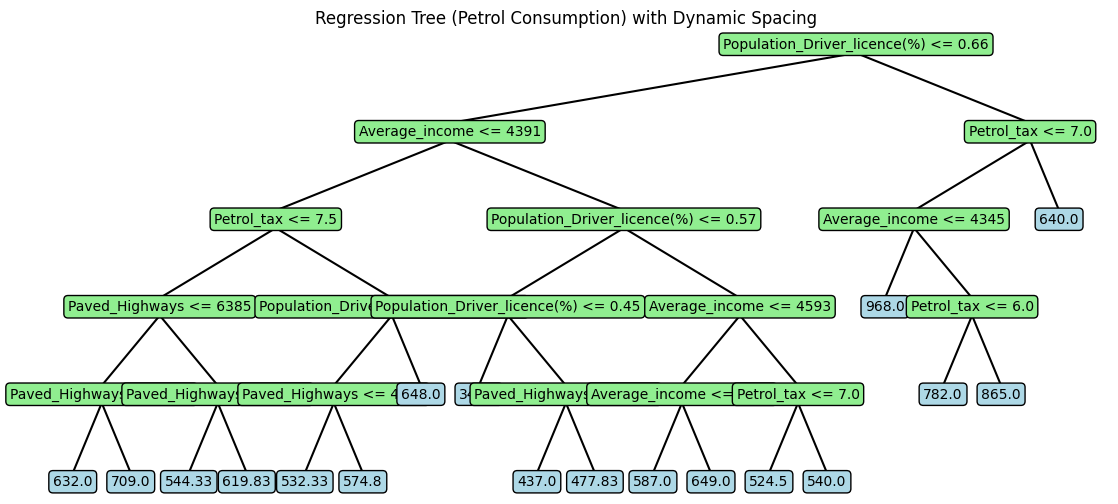

In [41]:
# Build tree on full dataset
tree_full = build_tree(df.iloc[:, :-1], df.iloc[:, -1], max_depth=5)

# Assign positions
positions = assign_positions(tree_full)

# Plot dynamically spaced tree
ax = plot_tree_dynamic(tree_full, positions)
plt.title("Regression Tree (Petrol Consumption) with Dynamic Spacing")
plt.show()
